In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
from keras import regularizers
from keras.layers import LeakyReLU

In [58]:
df = pd.read_csv('mag7.csv', index_col="Date", parse_dates=True)

In [59]:
df.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2014-11-24,29.657499,16.782000,27.374001,74.010002,47.590000,0.51450,16.448000
2014-11-25,29.400000,16.752001,27.461500,75.629997,47.470001,0.51425,16.539333
2014-11-26,29.750000,16.678499,27.386499,77.620003,47.750000,0.52300,16.562668
2014-11-28,29.732500,16.931999,27.454000,77.699997,47.810001,0.52425,16.301332
2014-12-01,28.767500,16.299999,26.982500,75.099998,48.619999,0.51450,15.442667


In [60]:
df.describe()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000
mean,94.057333,99.079404,81.062714,216.702748,183.595726,19.355752,111.591938
std,63.735143,53.441023,42.836502,116.049932,120.972201,29.999172,110.706607
min,22.584999,14.347500,24.853001,74.010002,40.290001,0.478500,9.578000
25%,36.456251,47.692999,46.849501,133.445000,69.080002,3.332500,16.967999
50%,63.702499,93.835503,62.955502,181.440002,146.919998,6.321500,24.749332
75%,150.815002,152.216499,117.897251,275.569992,279.629990,20.349500,217.726669
max,236.479996,214.100006,191.179993,595.940002,467.559998,148.880005,409.970001


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2014-11-24 to 2024-11-20
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2515 non-null   float64
 1   AMZN    2515 non-null   float64
 2   GOOGL   2515 non-null   float64
 3   META    2515 non-null   float64
 4   MSFT    2515 non-null   float64
 5   NVDA    2515 non-null   float64
 6   TSLA    2515 non-null   float64
dtypes: float64(7)
memory usage: 157.2 KB


In [62]:
def plot_stock_prices(df):
  # Plot each stock's time series
  plt.figure(figsize=(12, 8))
  for column in df.columns:
      plt.plot(df.index, df[column], label=column)

  plt.xlabel("Date")
  plt.ylabel("Closing Price")
  plt.title("Magnificent 7 Stock Prices")
  plt.legend()
  plt.grid(True)
  plt.show()

  return

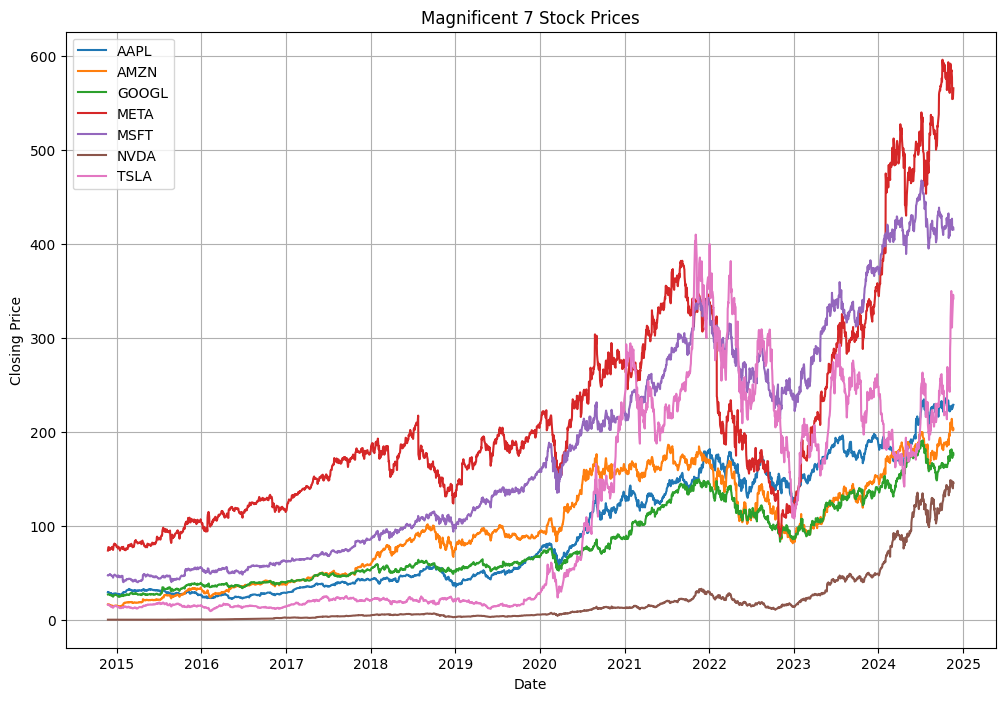

In [63]:
plot_stock_prices(df)

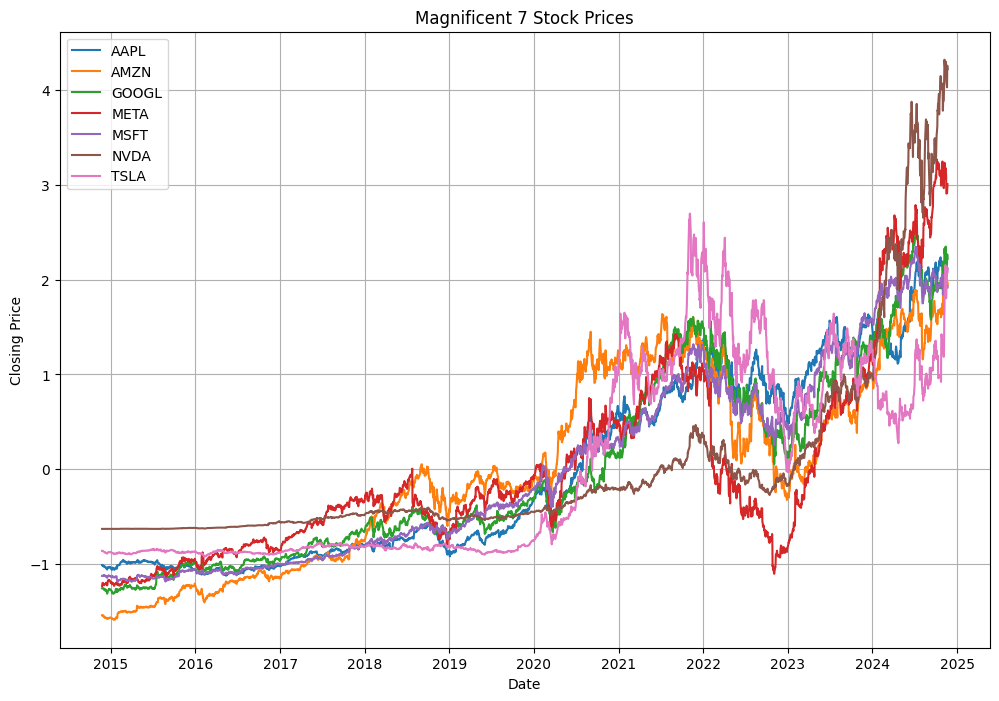

In [64]:
# Create a dictionary to store scalers for each stock
scalers = {}

# Scale each stock independently
for column in df.columns:
    scalers[column] = StandardScaler()
    df[column] = scalers[column].fit_transform(df[[column]])

plot_stock_prices(df)

In [65]:
# Define the split percentages (80% train, 10% validation, 10% test)
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Calculate split indices based on the size of the data
n = len(df)
train_index = int(n * train_size)
val_index = int(n * (train_size + val_size))

# Split the data
df_train = df[:train_index]
df_val = df[train_index:val_index]
df_test = df[val_index:]


# Convert to NumPy arrays if needed for your RNN model
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values

print(f"Train Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {val_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Train Data Shape: (2012, 7)
Validation Data Shape: (251, 7)
Test Data Shape: (252, 7)


In [13]:
def train_rnn_model(df_train, df_val, df_test, sequence_length, learning_rate=0.001, epochs=100, batch_size=32, patience=20, scalers=None, l1_reg=0.001, l2_reg=0.001):
    """
    Trains a stacked LSTM model on the provided pre-split DataFrames.

    """

    # Fix random seeds
    seed_value = 42
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    # Convert DataFrames to NumPy arrays
    train_data = df_train.values
    val_data = df_val.values
    test_data = df_test.values

    # Create sequences
    def create_sequences(data, sequence_length):
        X = []
        y = []
        for i in range(len(data) - sequence_length - 1):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length + 1])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_val, y_val = create_sequences(val_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], df_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], df_val.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], df_test.shape[1]))

    model = keras.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LeakyReLU(negative_slope=0.4))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(df_train.shape[1]))

    # Define optimizer with learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta = 0.0005)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr], verbose=1
    )

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)

    # Make predictions
    predictions = model.predict(X_test)

     #Inverse transform using provided scalers
    if scalers is None:
        scalers = {}
        for i in range(7):
            scalers[i] = StandardScaler()
            scalers[i].fit(y_train[:, i].reshape(-1, 1))
            predictions[:, i] = scalers[i].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()
            y_test[:, i] = scalers[i].inverse_transform(y_test[:, i].reshape(-1, 1)).flatten()
    else:
        pass

    train_plot_data = df_train.copy()
    val_plot_data = df_val.copy()
    test_plot_data = df_test.copy()

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    for i, col in enumerate(df.columns):
        train_plot_data[col] = scalers[col].inverse_transform(df_train[[col]])
        val_plot_data[col] = scalers[col].inverse_transform(df_val[[col]])
        test_plot_data[col] = scalers[col].inverse_transform(df_test[[col]])
        predictions[:, i] = scalers[col].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()

    full_predictions = np.concatenate([np.full((sequence_length + 1, df.shape[1]), np.nan), predictions])

    # Offset predictions to align with test data
    sequence_offset = sequence_length + 1  # Sequence length + 1 for y offset
    aligned_test_index = test_plot_data.index[sequence_offset:]  # Align indices


    for i, col in enumerate(df.columns):
      plt.figure(figsize=(15, 6))
      # Plot training, validation, and test data
      plt.plot(train_plot_data.index, train_plot_data[col], label='Training Data', color='blue')
      plt.plot(val_plot_data.index, val_plot_data[col], label='Validation Data', color='orange')
      plt.plot(test_plot_data.index, test_plot_data[col], label='Test Data (Full)', color='green')
      aligned_test_index = test_plot_data.index[-predictions.shape[0]:]
      plt.plot(aligned_test_index, predictions[:, i], label='Predictions', color='red')
      plt.title(f'{col} - Actual vs. Predicted')
      plt.xlabel('Date')
      plt.ylabel('Price')
      plt.legend()
      plt.grid(True)
      plt.show()


    return {
        "model": model,
        "history": history,
        "rmse": rmse,
        "mae": mae,
        "scalers": scalers
    }

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.2181 - val_loss: 0.3639 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0574 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0410 - val_loss: 0.2130 - learning_rate: 0.0010
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0372 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0327 - val_loss: 0.1615 - learning_rate: 0.0010
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0300 - val_loss: 0.1397 - learning_rate: 0.0010
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0270 - val_loss: 0.1773 - learning_rate: 0.0010
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0281 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0248 - val_loss: 0.1598 - learning_rate: 0.0010
Epoch 10/1

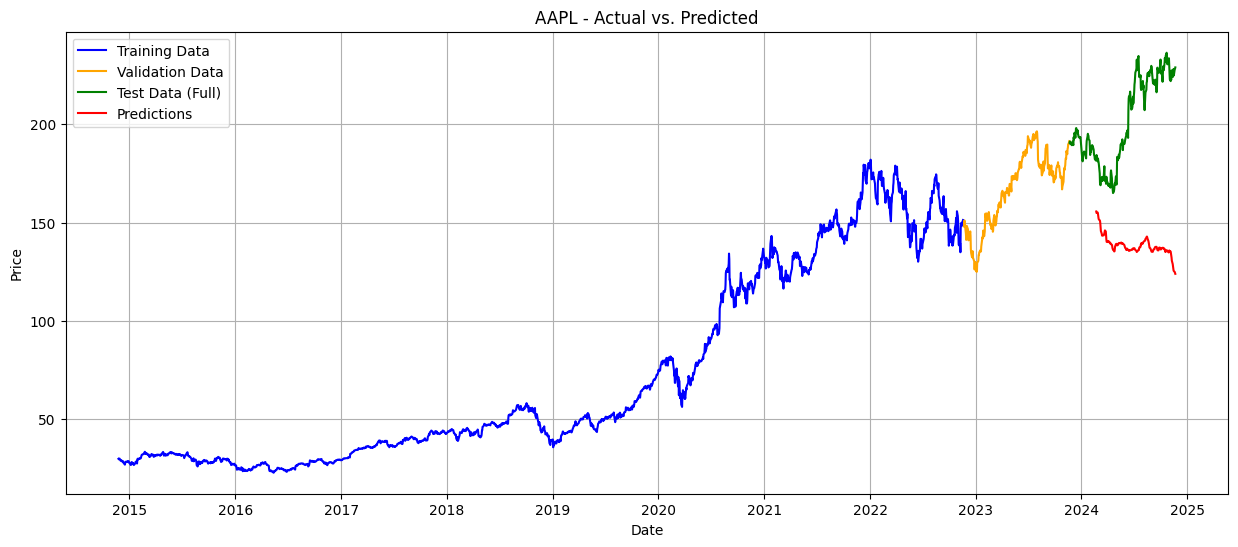

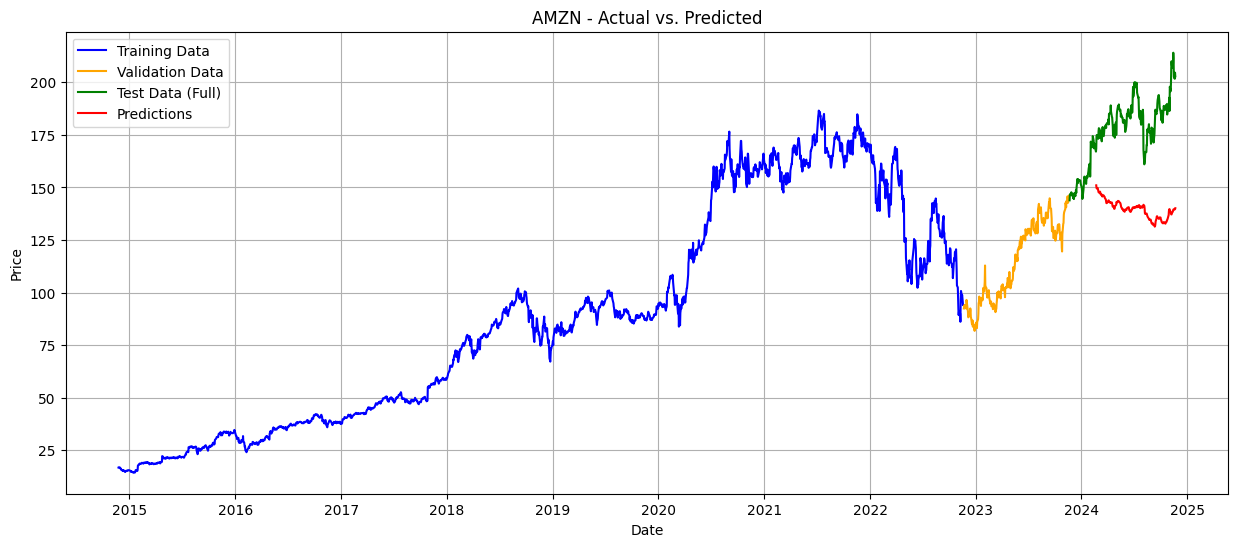

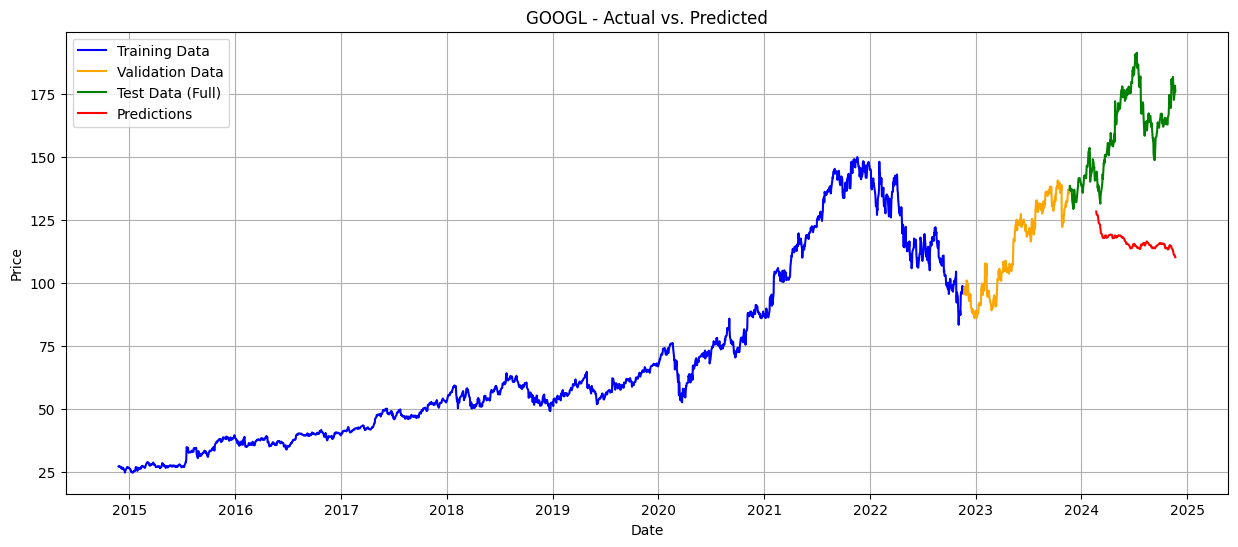

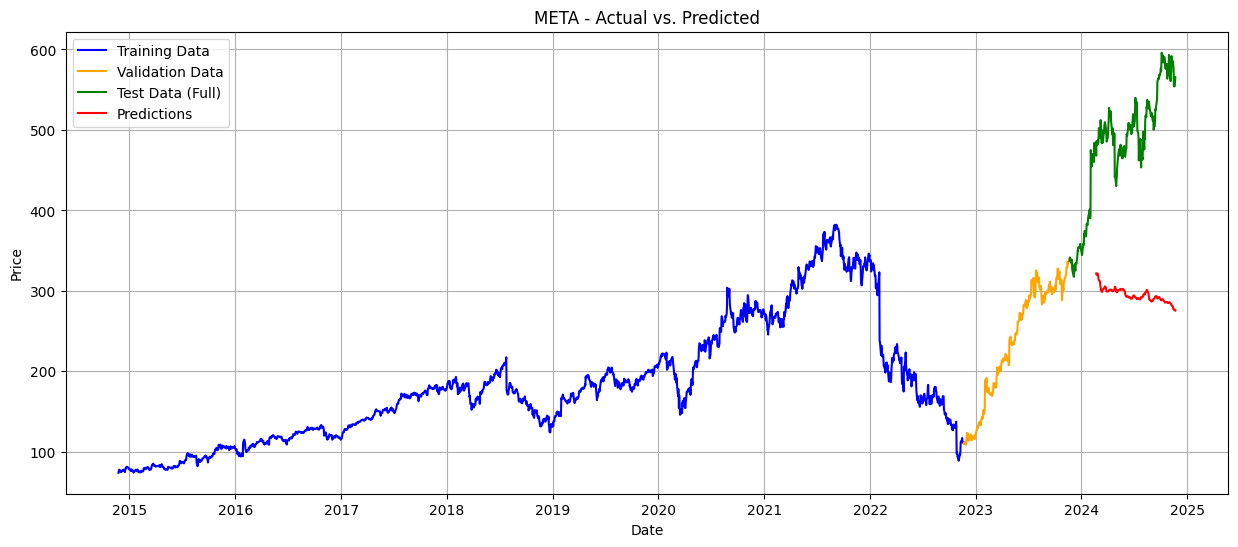

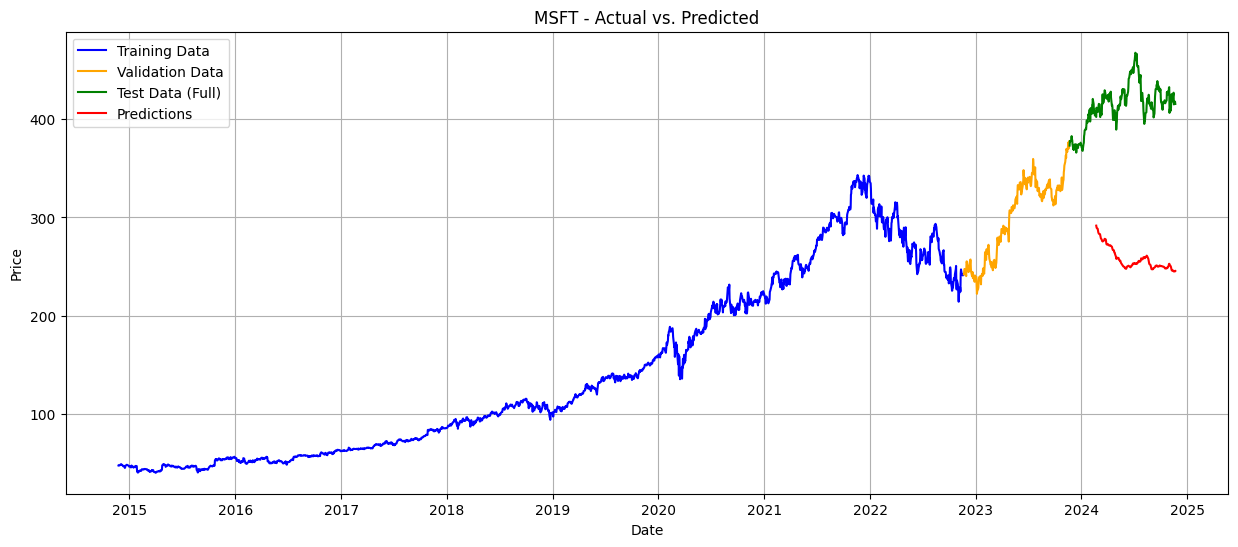

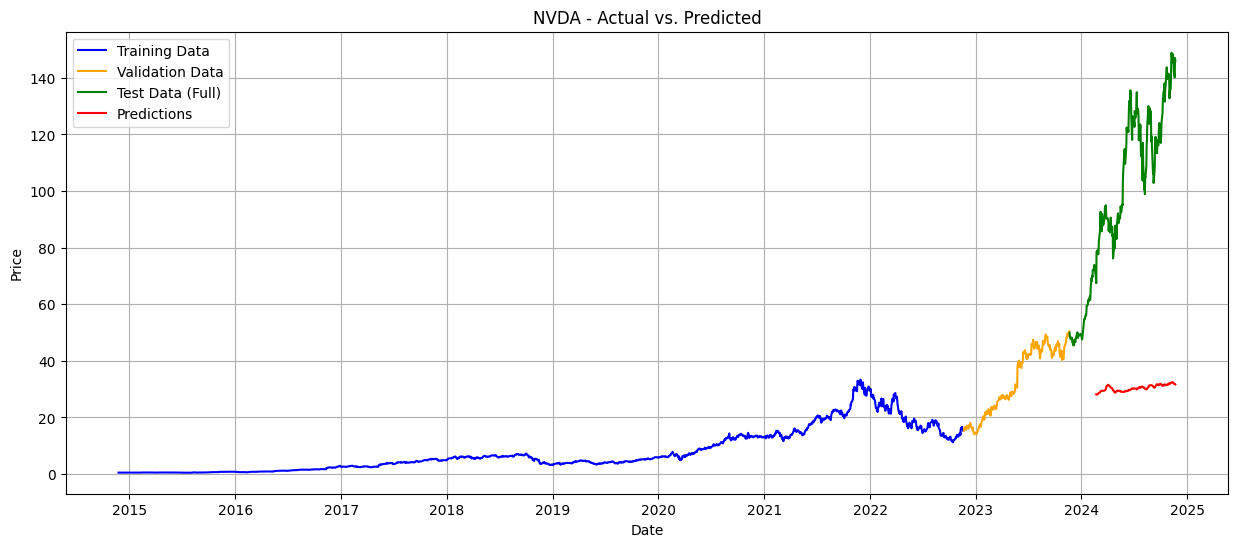

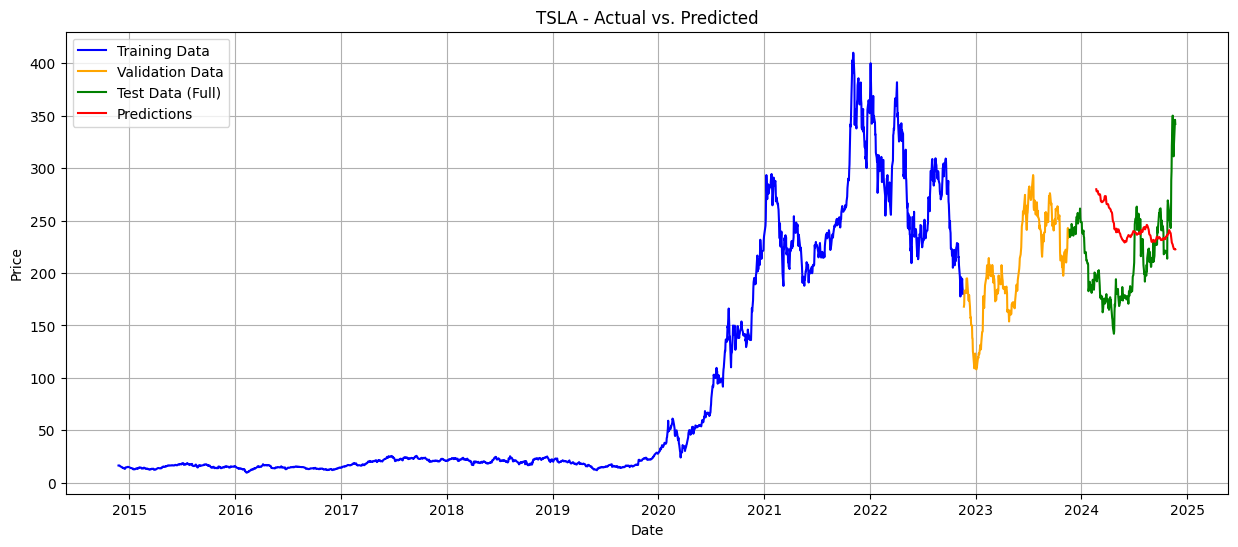

RMSE: 1.564039438820553
MAE: 1.3459959146416214


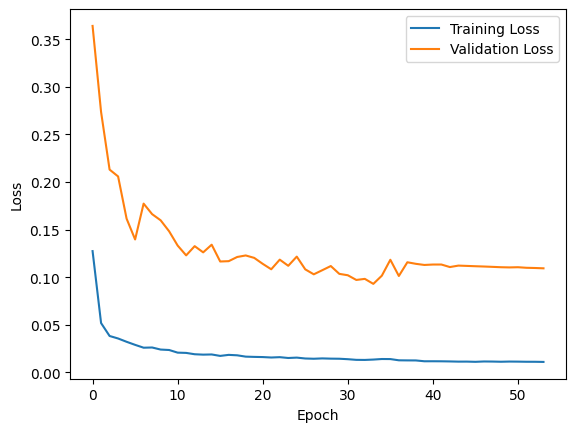

In [14]:
results = train_rnn_model(df_train.copy(), df_val.copy(), df_test.copy(),
                          sequence_length=60, batch_size=64, learning_rate=0.001, epochs=150, scalers=scalers,
                          l1_reg=0.0013, l2_reg=0.00125)
print(f"RMSE: {results['rmse']}")
print(f"MAE: {results['mae']}")

# Access the trained model and history
model = results['model']
history = results['history']
scalers = results['scalers']

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Train X Shape: (1982, 30, 7), Train y Shape: (1982, 7)
Validation X Shape: (221, 30, 7), Validation y Shape: (221, 7)
Test X Shape: (222, 30, 7), Test y Shape: (222, 7)
Epoch 1/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 4.6374 - mae: 0.9414 - mse: 1.4713 - val_loss: 3.4777 - val_mae: 0.5911 - val_mse: 0.5341 - learning_rate: 0.0010
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4937 - mae: 0.6328 - mse: 0.6410 - val_loss: 2.8830 - val_mae: 0.4112 - val_mse: 0.3134 - learning_rate: 0.0010
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.8736 - mae: 0.4995 - mse: 0.3999 - val_loss: 2.4080 - val_mae: 0.3335 - val_mse: 0.2199 - learning_rate: 0.0010
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3216 - mae: 0.3715 - mse: 0.2249 - val_loss: 2.0661 - val_mae: 0.3614 - val_mse: 0.2363 - learning_rate: 0.0010
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8787 - mae: 0.2830 - mse: 0.1312 - val_loss: 1.7276 - val_mae: 0.3531 - v

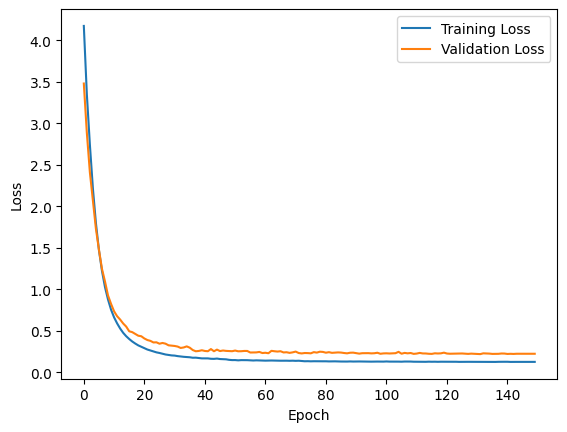

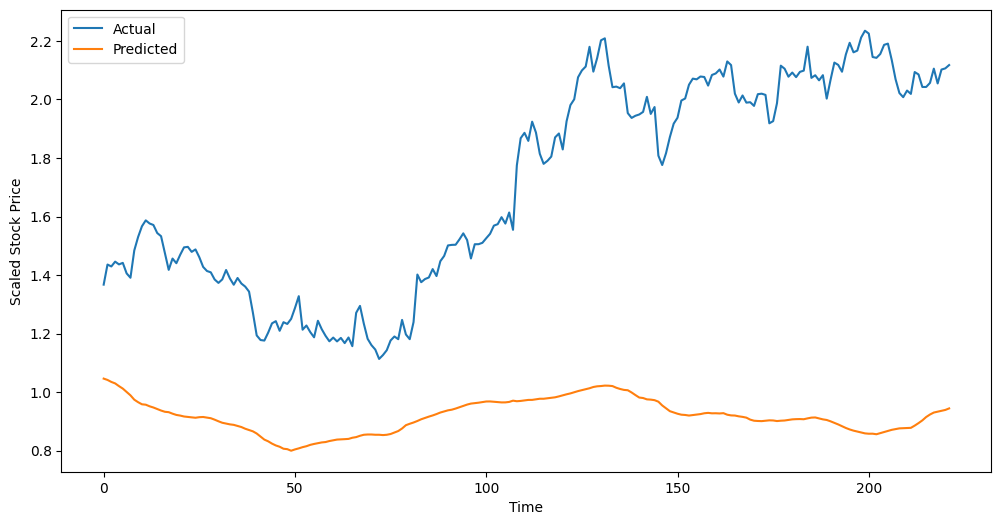

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, MultiHeadAttention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import l1_l2
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LayerNormalization, Add

def custom_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))

    # Directional error: based on signs of differences between predictions and actuals
    directional_error = K.mean(K.square(K.sign(y_true - y_pred)))

    return mse + 0.1 * directional_error

def build_attention_model(sequence_length, num_features, l1_reg=0.001, l2_reg=0.001):
    inputs = Input(shape=(sequence_length, num_features))

    # First LSTM Layer
    x = LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(inputs)
    x = LayerNormalization()(x)

    # Multi-Head Attention Layer
    attention1 = MultiHeadAttention(num_heads=6, key_dim=64)(x, x)
    attention1 = Add()([attention1, x])  # Residual connection
    attention1 = LayerNormalization()(attention1)
    attention1 = Dropout(0.3)(attention1)

    # Second LSTM Layer
    x = LSTM(64, return_sequences=True, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(attention1)
    x = LayerNormalization()(x)

    # Second Attention Layer
    attention2 = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    attention2 = Add()([attention2, x])  # Residual connection
    attention2 = LayerNormalization()(attention2)
    attention2 = Dropout(0.3)(attention2)

    # Global Pooling and Final Dense Layer
    x = GlobalAveragePooling1D()(attention2)
    x = Dropout(0.4)(x)
    outputs = Dense(num_features)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=custom_loss, metrics=['mae', 'mse'])
    return model


# Create sequences and their shifted targets
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])  # Predict the next timestep
    return np.array(X), np.array(y)

# Prepare data
sequence_length = 30  # Define the sequence length
train_X, train_y = create_sequences(df_train.values, sequence_length)
val_X, val_y = create_sequences(df_val.values, sequence_length)
test_X, test_y = create_sequences(df_test.values, sequence_length)

print(f"Train X Shape: {train_X.shape}, Train y Shape: {train_y.shape}")
print(f"Validation X Shape: {val_X.shape}, Validation y Shape: {val_y.shape}")
print(f"Test X Shape: {test_X.shape}, Test y Shape: {test_y.shape}")

# Train the model
model = build_attention_model(sequence_length, train_X.shape[2], l1_reg=0.0013, l2_reg=0.00125)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Number of epochs with no improvement
    restore_best_weights=True
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    epochs=150, batch_size=64,
    callbacks=[early_stopping, ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)]
)

# Evaluate the model
predictions = model.predict(test_X)
rmse = np.sqrt(np.mean((predictions - test_y) ** 2))
mae = np.mean(np.abs(predictions - test_y))
print(f"Test RMSE: {rmse}, Test MAE: {mae}")

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_y[:, 0], label="Actual")
plt.plot(predictions[:, 0], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Scaled Stock Price")
plt.legend()
plt.show()


Processing Company: AAPL
Epoch 1/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 4.2604 - mae: 1.0418 - mse: 1.9222 - val_loss: 2.5473 - val_mae: 0.4799 - val_mse: 0.2724 - learning_rate: 0.0010
Epoch 2/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.5913 - mae: 0.4689 - mse: 0.3447 - val_loss: 2.1995 - val_mae: 0.1780 - val_mse: 0.0464 - learning_rate: 0.0010
Epoch 3/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2855 - mae: 0.3218 - mse: 0.1664 - val_loss: 2.0699 - val_mae: 0.1976 - val_mse: 0.0570 - learning_rate: 0.0010
Epoch 4/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0837 - mae: 0.2572 - mse: 0.1068 - val_loss: 1.9938 - val_mae: 0.3102 - val_mse: 0.1265 - learning_rate: 0.0010
Epoch 5/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9000 - mae: 0.2057 - mse: 0.0686 - val_loss: 1.8003 - val_mae: 0.2324 - val_mse: 0.0767 - learning_rate: 0.0010
Epoch 6/150
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7390 - mae: 0.1745 - mse: 0.0496 - val_loss

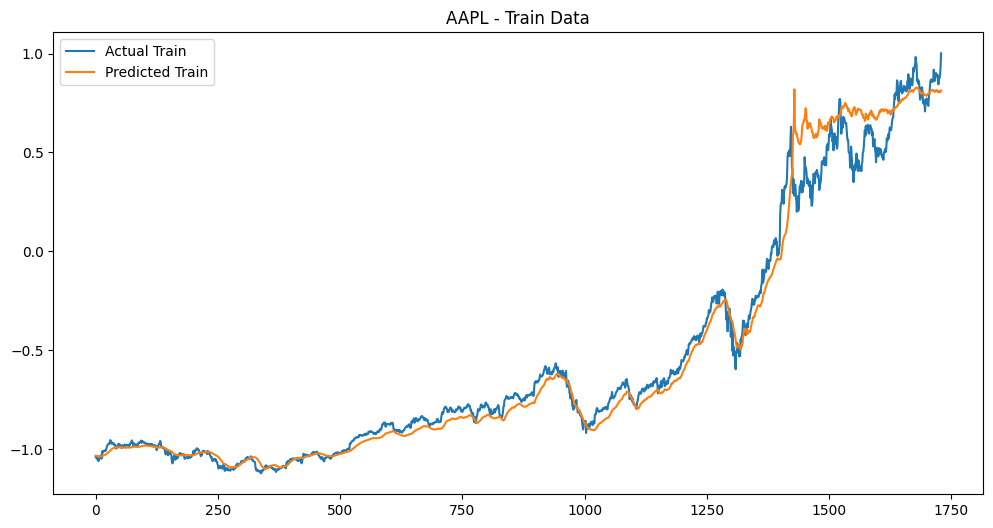

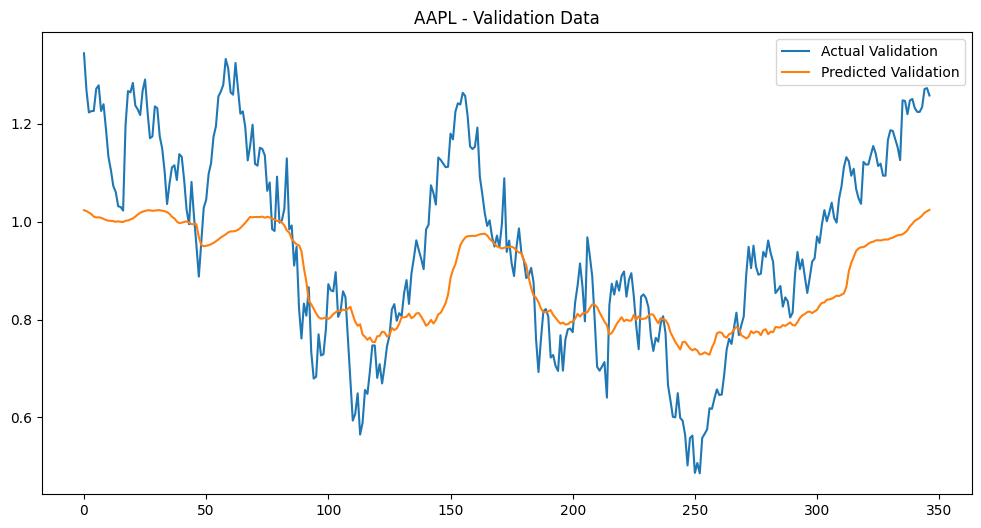

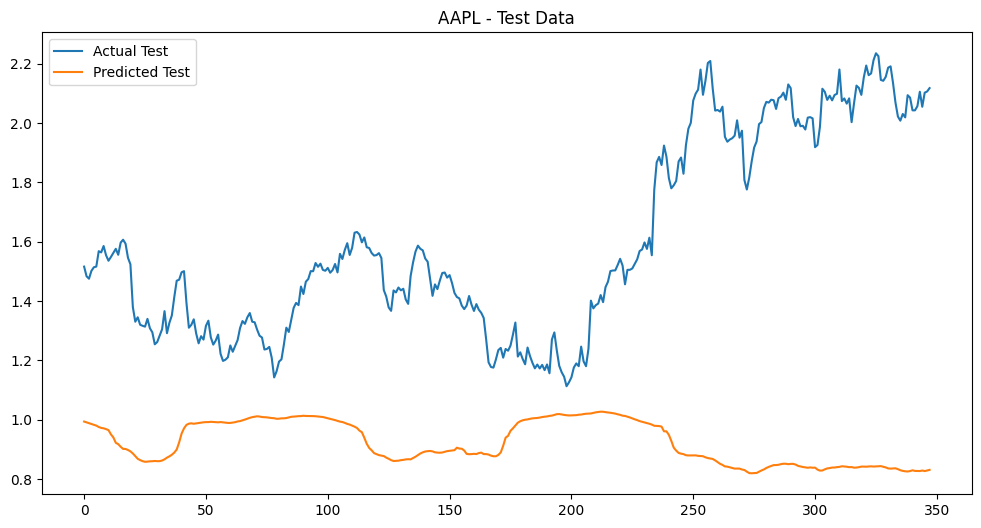

Plotting Results for AMZN


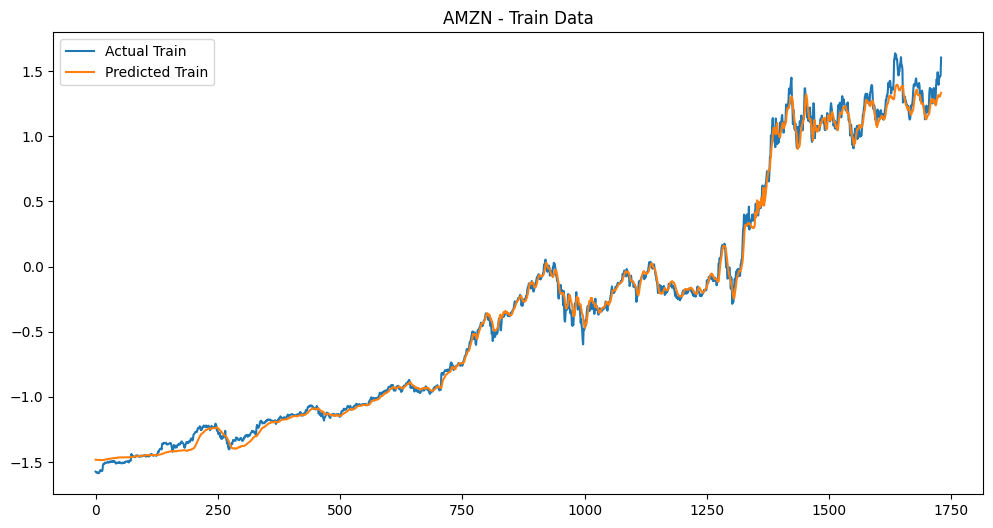

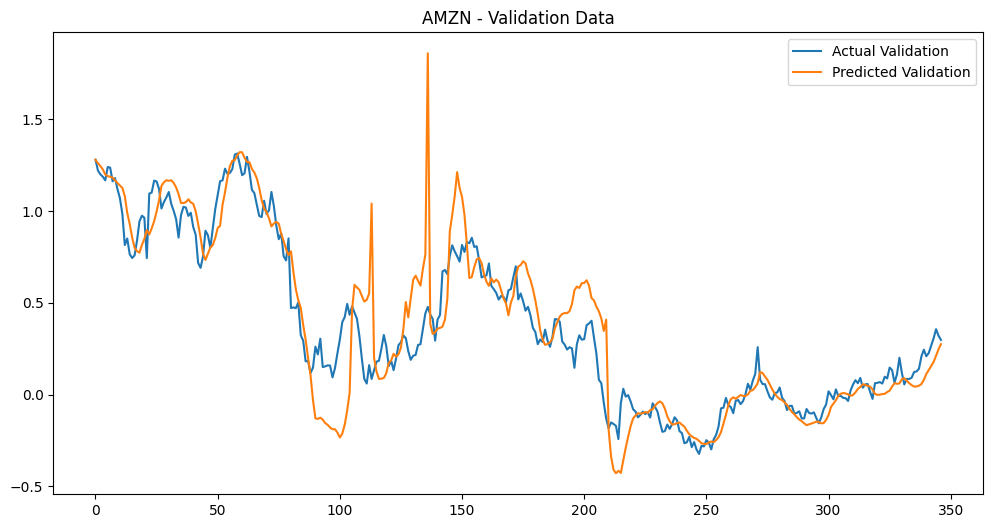

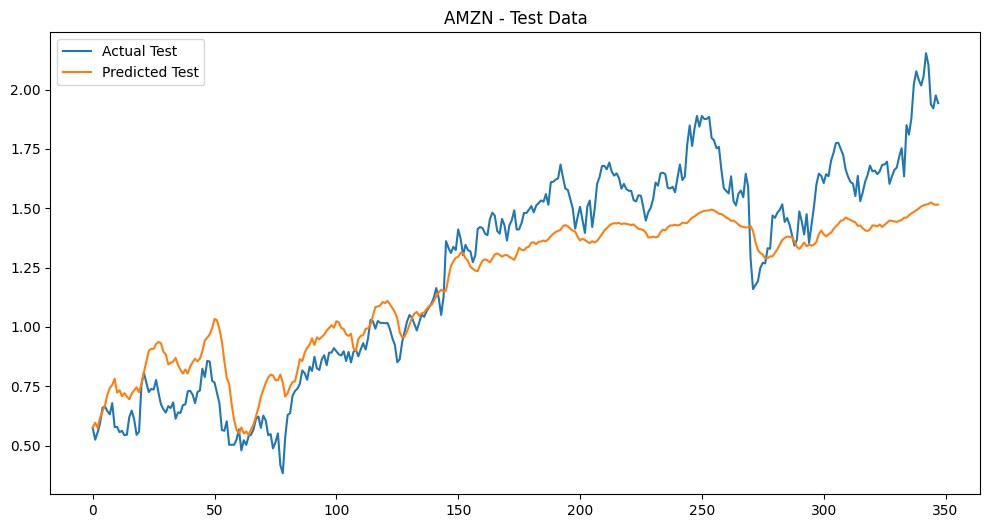

Plotting Results for GOOGL


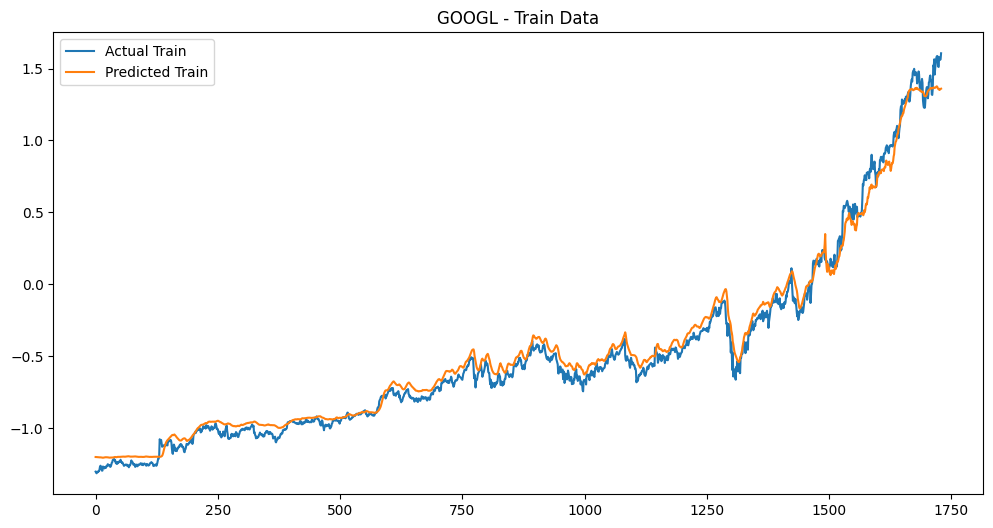

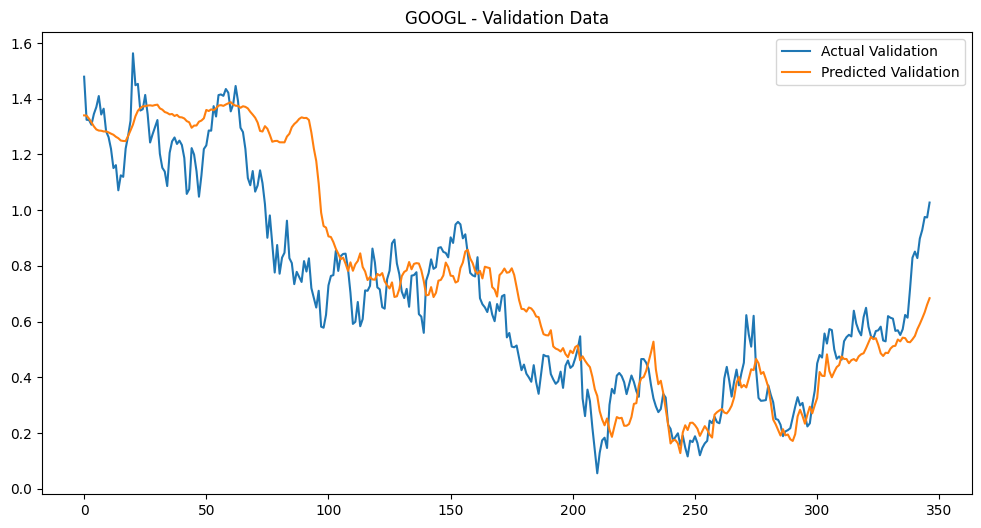

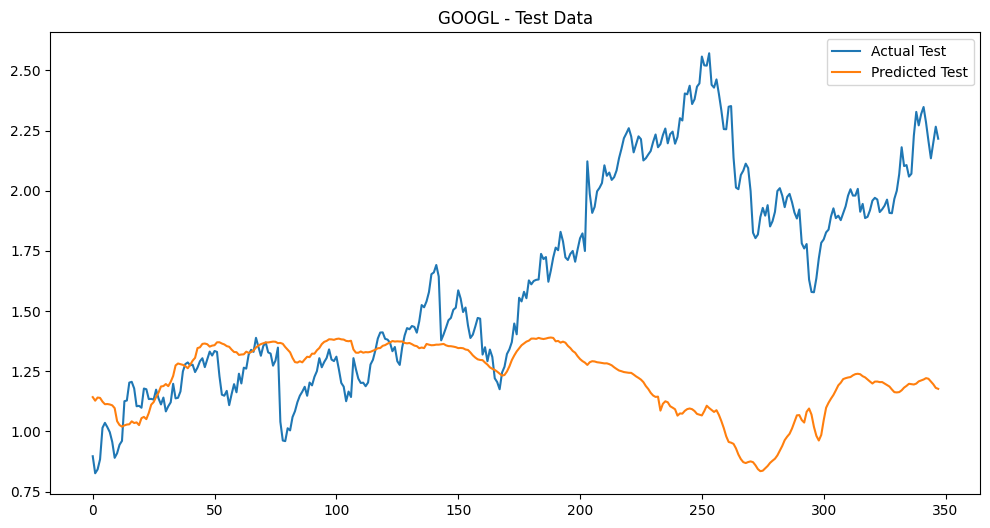

Plotting Results for META


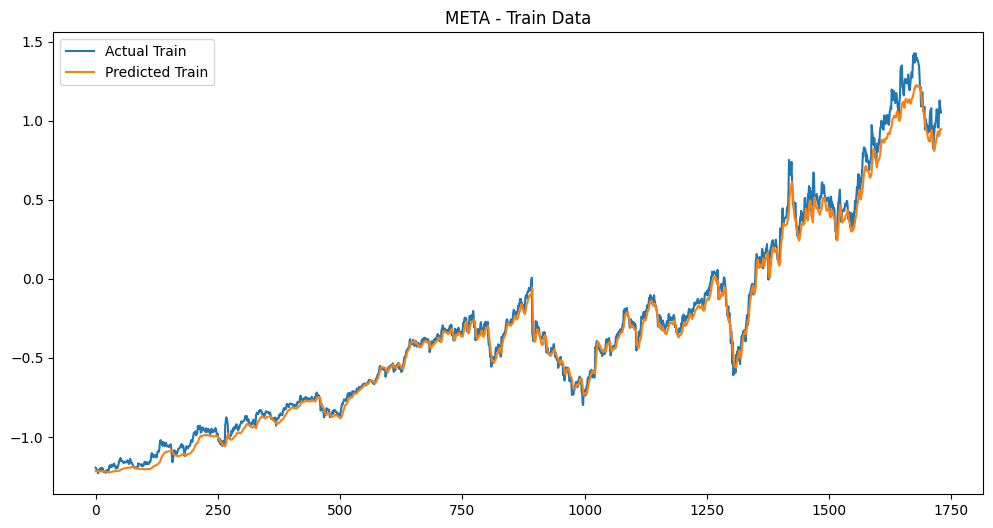

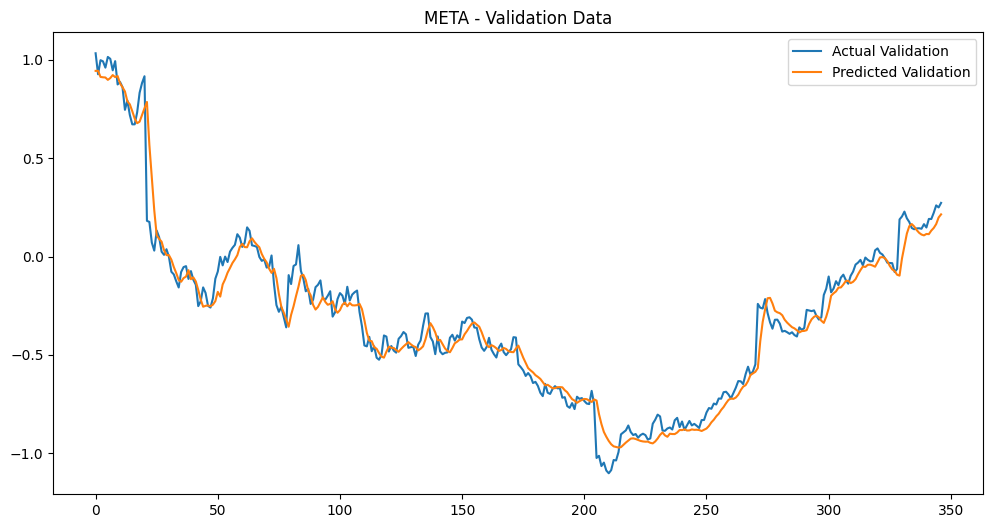

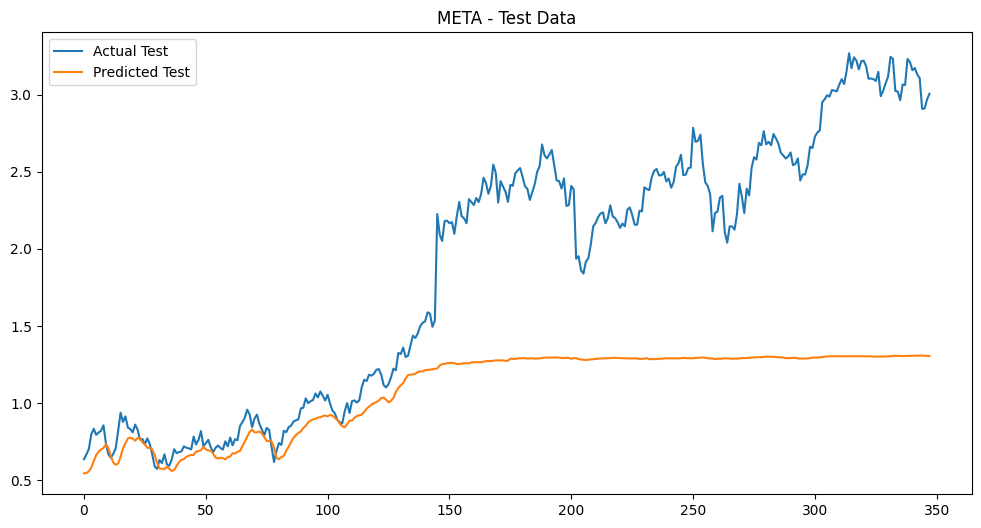

Plotting Results for MSFT


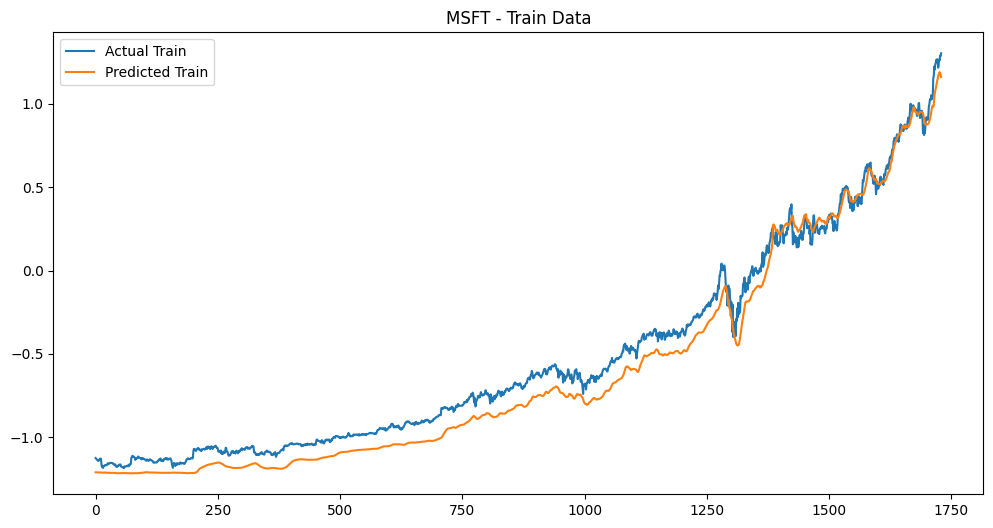

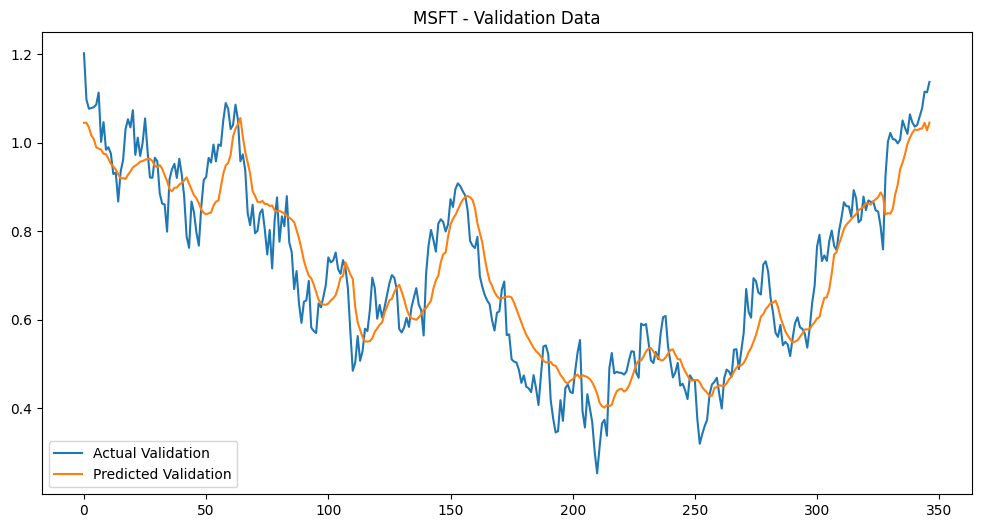

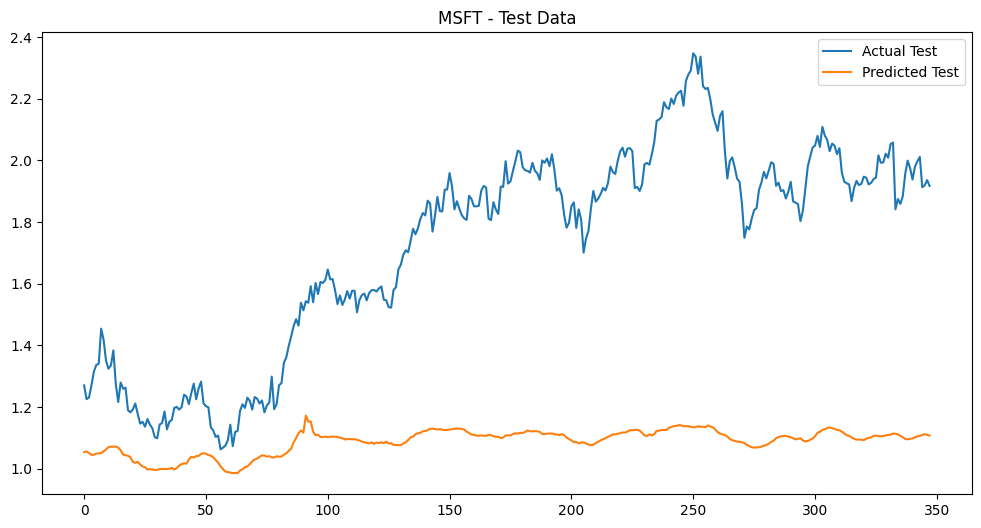

Plotting Results for NVDA


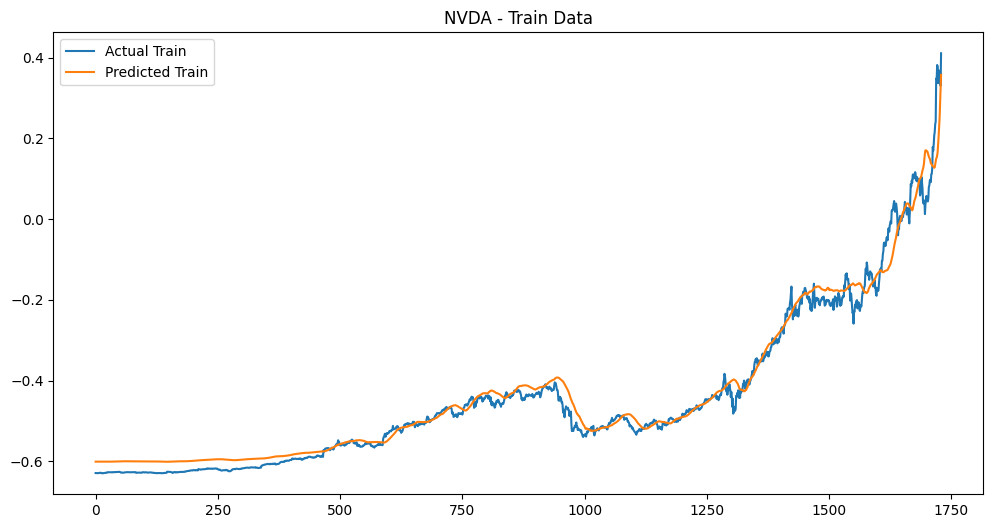

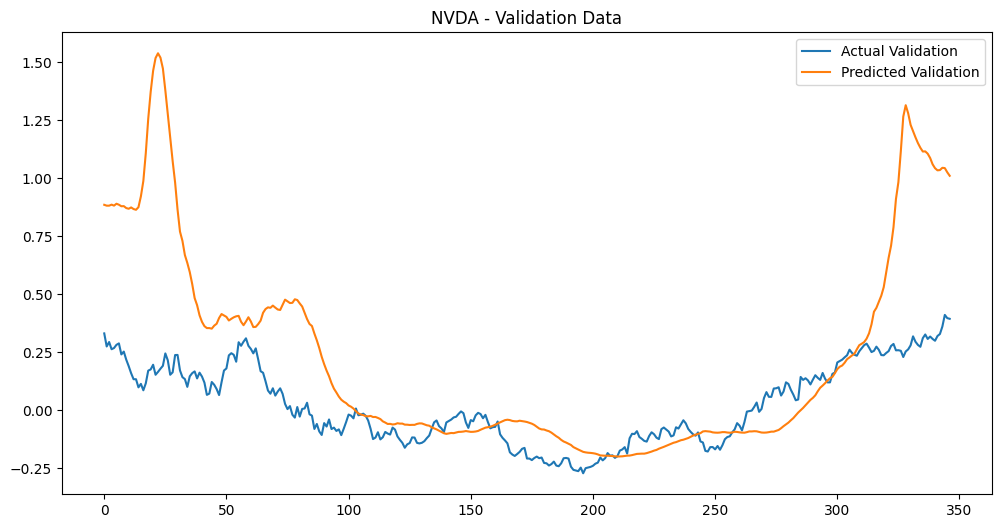

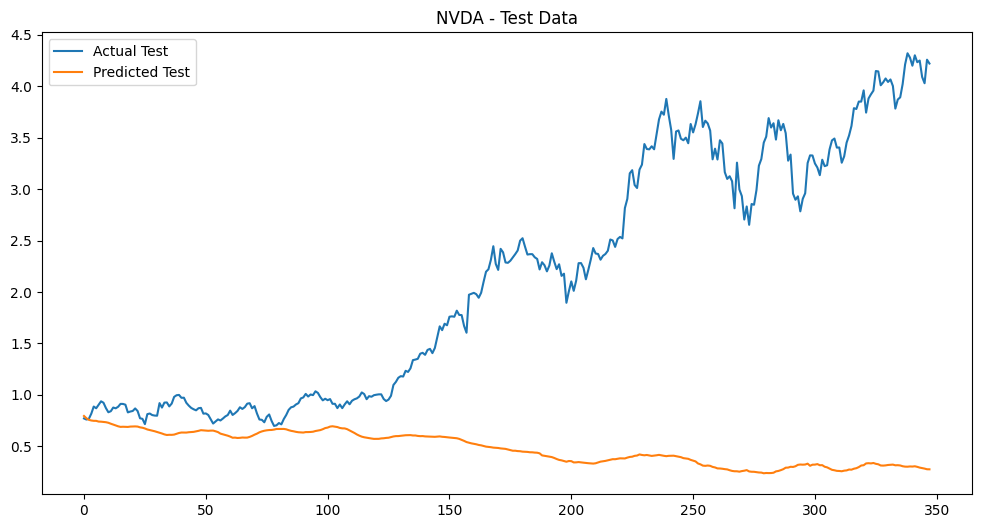

Plotting Results for TSLA


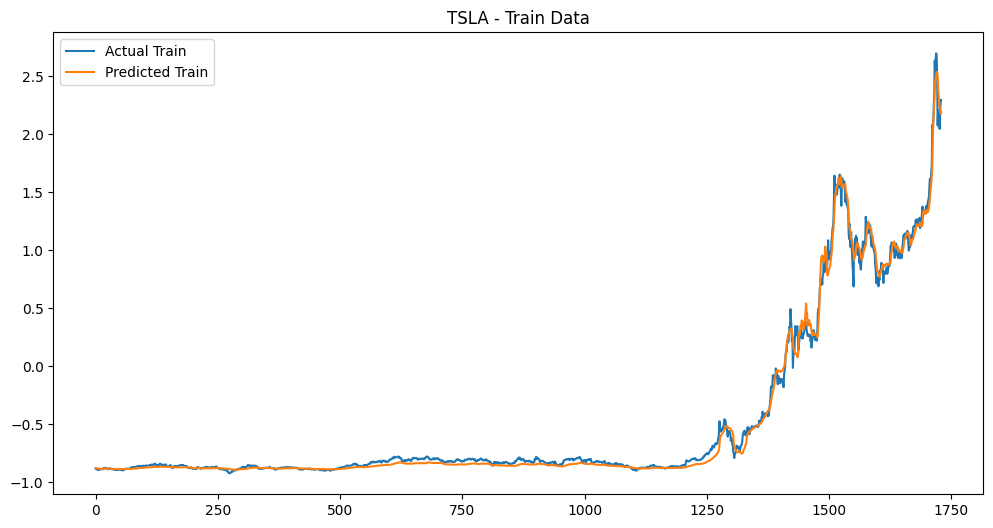

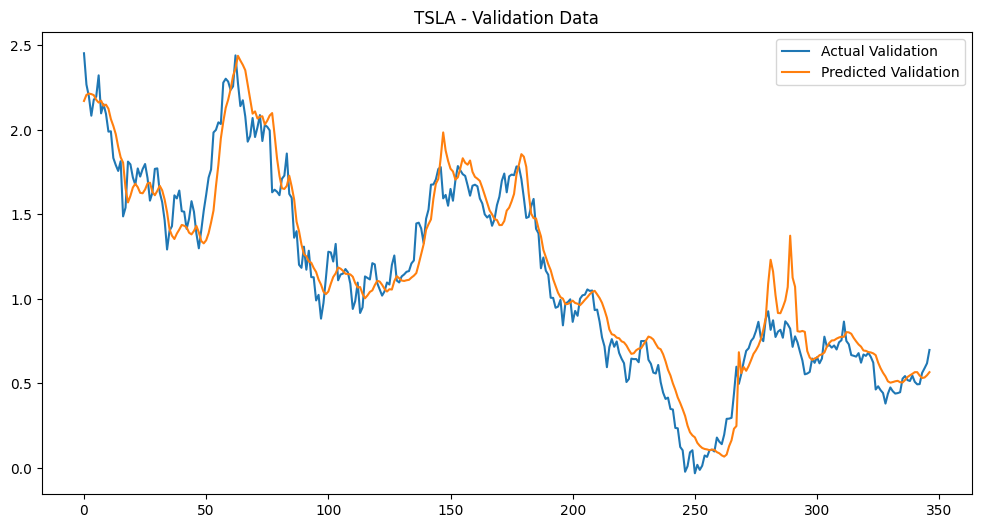

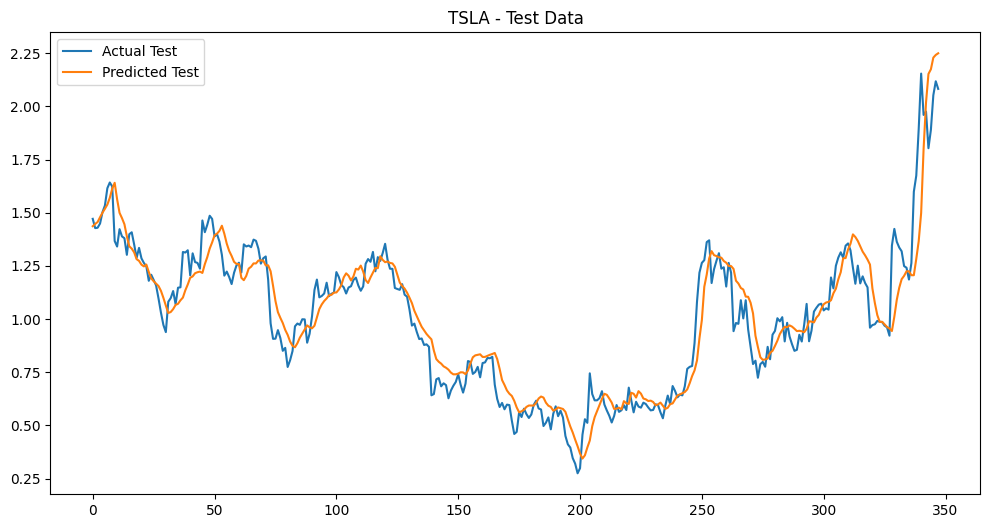

In [95]:
# Function to process and predict for each company
def process_and_predict(df, sequence_length=30):
    results = {}

    # Iterate over each company (column in the dataframe)
    for company in df.columns:
        print(f"Processing Company: {company}")

        # Extract the data for the company
        company_data = df[company].values

        # Split into training, validation, and test sets (70% train, 15% val, 15% test)
        train_data, val_data, test_data = np.split(company_data, [int(0.7 * len(company_data)), int(0.85 * len(company_data))])

        # Create sequences for the company's data
        train_X, train_y = create_sequences(train_data, sequence_length)
        val_X, val_y = create_sequences(val_data, sequence_length)
        test_X, test_y = create_sequences(test_data, sequence_length)

        # Build and train the model
        model = build_attention_model(sequence_length, num_features=1)  # Only 1 feature per company
        early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

        history = model.fit(
            train_X, train_y,
            validation_data=(val_X, val_y),
            epochs=150, batch_size=64,
            callbacks=[
                early_stopping,
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
            ]
        )

        # Make predictions
        train_predictions = model.predict(train_X)
        val_predictions = model.predict(val_X)
        test_predictions = model.predict(test_X)

        # Store results
        results[company] = {
            "train": {"actual": train_y, "predicted": train_predictions},
            "val": {"actual": val_y, "predicted": val_predictions},
            "test": {"actual": test_y, "predicted": test_predictions},
        }

        # Evaluate the model
        train_rmse = np.sqrt(np.mean((train_predictions - train_y) ** 2))
        val_rmse = np.sqrt(np.mean((val_predictions - val_y) ** 2))
        test_rmse = np.sqrt(np.mean((test_predictions - test_y) ** 2))

        print(f"{company} RMSE: Train={train_rmse}, Val={val_rmse}, Test={test_rmse}")

    return results

# Call the function and get the results
results = process_and_predict(df)
def plot_results(results):
    for company, data in results.items():
        print(f"Plotting Results for {company}")

        # Plot Train Data
        plt.figure(figsize=(12, 6))
        plt.plot(data["train"]["actual"], label="Actual Train")
        plt.plot(data["train"]["predicted"], label="Predicted Train")
        plt.title(f"{company} - Train Data")
        plt.legend()
        plt.show()

        # Plot Validation Data
        plt.figure(figsize=(12, 6))
        plt.plot(data["val"]["actual"], label="Actual Validation")
        plt.plot(data["val"]["predicted"], label="Predicted Validation")
        plt.title(f"{company} - Validation Data")
        plt.legend()
        plt.show()

        # Plot Test Data
        plt.figure(figsize=(12, 6))
        plt.plot(data["test"]["actual"], label="Actual Test")
        plt.plot(data["test"]["predicted"], label="Predicted Test")
        plt.title(f"{company} - Test Data")
        plt.legend()
        plt.show()

# Call the plot function
plot_results(results)
